In [1]:
import os
import datetime

#打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

#mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" 

In [2]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader,TensorDataset

In [3]:
#样本数量
n = 400

# 生成测试用数据集
X = 10*torch.rand([n,2])-5.0  #torch.rand是均匀分布 
w0 = torch.tensor([[2.0],[-3.0]])
b0 = torch.tensor([[10.0]])
Y = X@w0 + b0 + torch.normal( 0.0,2.0,size = [n,1])  # @表示矩阵乘法,增加正态扰动

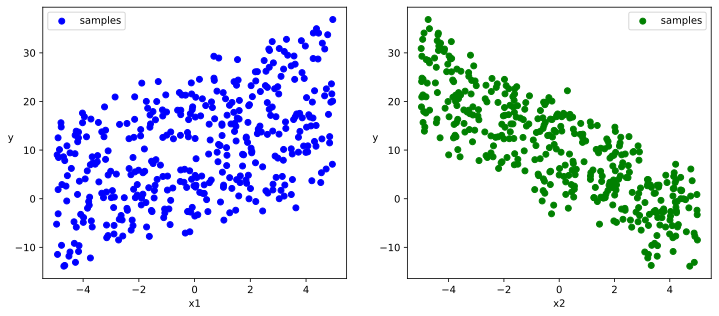

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()

In [5]:
#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,num_workers=2)

In [6]:
model = nn.Linear(2,1) #线性层

model.loss_func = nn.MSELoss() 
# ！！！看这个，关键！！！！

model.optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

In [13]:
def train_step(model, features, labels):
    
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    loss.backward()
    model.optimizer.step()
    model.optimizer.zero_grad()
    return loss.item()

# 测试train_step效果
features,labels = next(iter(dl))
train_step(model,features,labels)

108.96037292480469

In [14]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        for features, labels in dl:# ！！！看这个，关键！！！！
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            w = model.state_dict()["weight"]
            # ！！！看这个，关键！！！！
            b = model.state_dict()["bias"]
            # ！！！看这个，关键！！！！
            print("epoch =",epoch,"loss = ",loss)
            print("w =",w)
            print("b =",b)
train_model(model,epochs = 200)


================================================================================2021-09-27 10:53:20
epoch = 50 loss =  4.546708106994629
w = tensor([[ 2.0112, -3.0556]])
b = tensor([9.8941])

================================================================================2021-09-27 10:53:55
epoch = 100 loss =  5.91877555847168
w = tensor([[ 2.1179, -3.0074]])
b = tensor([9.9237])

================================================================================2021-09-27 10:54:30
epoch = 150 loss =  2.659381628036499
w = tensor([[ 1.9499, -3.0039]])
b = tensor([9.9109])

================================================================================2021-09-27 10:55:05
epoch = 200 loss =  7.223672389984131
w = tensor([[ 2.0030, -2.9179]])
b = tensor([9.9041])


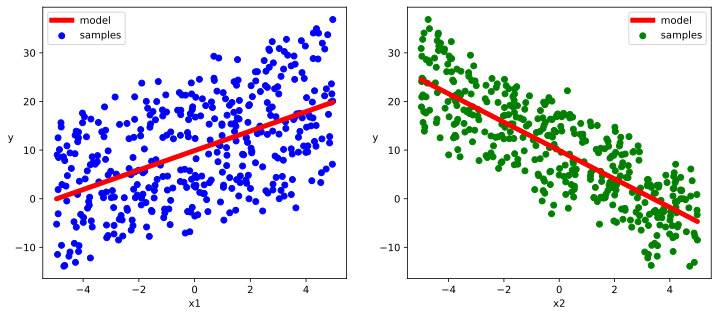

In [15]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

w,b = model.state_dict()["weight"],model.state_dict()["bias"]

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0,0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)



ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[0,1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

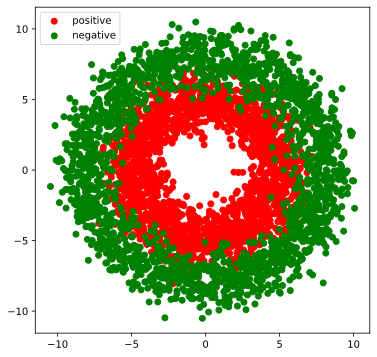

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0,1.0,size = [n_positive,1]) 
theta_p = 2*np.pi*torch.rand([n_positive,1])
Xp = torch.cat([r_p*torch.cos(theta_p),r_p*torch.sin(theta_p)],axis = 1)
Yp = torch.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0,1.0,size = [n_negative,1]) 
theta_n = 2*np.pi*torch.rand([n_negative,1])
Xn = torch.cat([r_n*torch.cos(theta_n),r_n*torch.sin(theta_n)],axis = 1)
Yn = torch.zeros_like(r_n)

#汇总样本
X = torch.cat([Xp,Xn],axis = 0)
Y = torch.cat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0],Xp[:,1],c = "r")
plt.scatter(Xn[:,0],Xn[:,1],c = "g")
plt.legend(["positive","negative"]);

In [17]:
#构建输入数据管道
ds = TensorDataset(X,Y)
dl = DataLoader(ds,batch_size = 10,shuffle=True,num_workers=2)

# ！！！看这个，关键！！！！
# ！！！看这个，关键！！！！
# ！！！看这个，关键！！！！

In [18]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel, self).__init__()
        self.fc1 = nn.Linear(2,4)
        self.fc2 = nn.Linear(4,8) 
        self.fc3 = nn.Linear(8,1)

    # 正向传播
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x))
        return y
    
    # 损失函数
    def loss_func(self,y_pred,y_true):
        return nn.BCELoss()(y_pred,y_true)# ！！！看这个，关键！！！！
                                           # ！！！看这个，关键！！！！
                                           # ！！！看这个，关键！！！！
    
    # 评估函数(准确率)
    def metric_func(self,y_pred,y_true):
        y_pred = torch.where(y_pred>0.5,torch.ones_like(y_pred,dtype = torch.float32),
                          torch.zeros_like(y_pred,dtype = torch.float32))
        acc = torch.mean(1-torch.abs(y_true-y_pred))
        return acc
    
    # 优化器
    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(),lr = 0.001) # ！！！看这个Adam，关键！！！！
                                                               # ！！！看这个Adam，关键！！！！
                                                               # ！！！看这个Adam，关键！！！！
    
model = DNNModel()

In [19]:
# 测试模型结构
(features,labels) = next(iter(dl))
predictions = model(features)

loss = model.loss_func(predictions,labels)
metric = model.metric_func(predictions,labels)

print("init loss:",loss.item())
print("init metric:",metric.item())

init loss: 0.7033255696296692
init metric: 0.4000000059604645


In [20]:
def train_step(model, features, labels):
    
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions,labels)
    metric = model.metric_func(predictions,labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 更新模型参数
    model.optimizer.step()
    model.optimizer.zero_grad()
    
    return loss.item(),metric.item()

# 测试train_step效果
features,labels = next(iter(dl))
train_step(model,features,labels)

(0.6408239603042603, 0.6000000238418579)

In [21]:
def train_model(model,epochs):
    for epoch in range(1,epochs+1):
        loss_list,metric_list = [],[]
        for features, labels in dl:
            lossi,metrici = train_step(model,features,labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)

        if epoch%100==0:
            printbar()
            print("epoch =",epoch,"loss = ",loss,"metric = ",metric)
        
train_model(model,epochs = 300)


================================================================================2021-09-27 11:01:24
epoch = 100 loss =  0.27881146259460365 metric =  0.9099999906122684

================================================================================2021-09-27 11:03:15
epoch = 200 loss =  0.2573487613947145 metric =  0.9147499926388264

================================================================================2021-09-27 11:05:02
epoch = 300 loss =  0.26263998576443554 metric =  0.9147499921917915


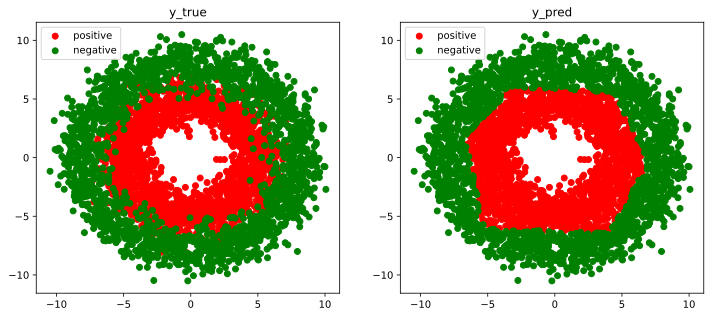

In [22]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1], c="r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = X[torch.squeeze(model.forward(X)>=0.5)]
Xn_pred = X[torch.squeeze(model.forward(X)<0.5)]

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");